In [19]:
import pandas as pd
import os
import sys
import re
import json
from tqdm import tqdm
import random
import pickle
from sklearn.model_selection import train_test_split

In [20]:
PATH_TO_LOAD = '../data/04_Merged'
sequence_split = False
if not sequence_split:
    random_split = True

session_dict_generation = False

In [21]:
def load_df(vehicle):
    df = pd.read_csv(os.path.join(PATH_TO_LOAD, vehicle + "_merged.csv"), parse_dates=['datetime'], low_memory=False)
    df_filt = df.drop(['index', 'avg_irradiation', 'steering_speed', 'temperature_out', 'hour',
                        'month', 'odometer', 'light_sensor_rear', 'light_sensor_front',
                        'temperature_in', 'KBI_speed', 'soc', 'ESP_speed', 'latitude',
                        'longitude', 'seatbelt_codriver', 'seatbelt_rear_l', 'seatbelt_rear_m',
                        'seatbelt_rear_r', 
                        'rain_sensor', 'street_category', 'kickdown', 'altitude',
                        'driving_program', 'CHA_MO_drive_mode',
                        'distance_driven', 'ts_normalized', 'weekday', 'CHA_ESP_drive_mode'], axis=1, inplace=False)
    df_filt = df_filt.dropna(subset=['Label'])
    df_filt_sort = df_filt.sort_values(by=['session','datetime'])
    return df_filt_sort

In [22]:
drive_mode_mapping = {
    '0.0': 'Normal',
    '1.0': 'Sport',
    '2.0': 'Super Sport',
    '3.0': 'Range',
    '4.0': 'Gravel / Offroad'
}

climate_label = {
    'clima': 'climate',
    'AC': 'air conditioning'
}

def replace_label(label):
    match = re.search(r'\d+\.\d+', label)
    if match:
        numeric_part = match.group()
        replacement = drive_mode_mapping.get(numeric_part, numeric_part)
        return label.replace(numeric_part, replacement)
    else:
        return label
    
def custom_concat(row):
    # Check if the "Label" column value is "media/selectedSource/Bluetooth"
    if row['Label'] == 'media/selectedSource/Bluetooth':
        return f"{row['Label']}:{row['FunctionValue']}"
    else:
        return row['Label']

def remove_consecutive_duplicates(row):
    words = row.split()  # Split the row into words
    unique_words = [words[0]]  # Initialize a list with the first word

    # Iterate through the words and add non-consecutive duplicates to the list
    for word in words[1:]:
        if word != unique_words[-1]:
            unique_words.append(word)

    return ' '.join(unique_words) 

In [23]:
def itemization(df):
    # Apply the function to the "Label" column
    
    df['Label'] = df['Label'].apply(replace_label)
    df['Label'] = df['Label'].replace(climate_label)
    df['Label'] = df['Label'].replace({'car/ESS/on' : '/car/eSoundSystem/on'})
    df['Label'] = df['Label'].replace({'clima/AC/off' : 'climate/AirConditioning/off'})
    df['Label'] = df['Label'].replace({'clima/AC/on' : 'climate/AirConditioning/on'})
    df['Label'] = df['Label'].replace({'clima/AC/ECO' : 'climate/AirConditioning/ECO'})
    df['Label'] = df.apply(custom_concat, axis=1)
    condition = df['FunctionValue'] == 'Bluetooth::BLUETOOTH'
    df['Label'] = df['Label'].str.replace('🦖', '')
    df['Label'] = df['Label'].str.replace('car/driveMode/0', 'car/driveMode/Normal')
    df['Label'] = df['Label'].str.replace('car/driveMode/2', 'car/driveMode/Super Sport')
    df['Label'] = df['Label'].str.replace('car/driveMode/3', 'car/driveMode/Range')
    df['Label'] = df['Label'].apply(remove_consecutive_duplicates)
    df['Label'] = df['Label'].str.replace('media/selectedSource/Favorite', 
                                                            'media/selectedSource/Favorite:TUNER_FAVORITES')
    df['Label'] = df['Label'].str.replace('media/selectedSource/CarPlay', 
                                                            'media/selectedSource/Apple CarPlay')
    df['Label'] = df['Label'].str.replace('phone/Start/CarPlay', 
                                                            'phone/Start/Apple CarPlay')
    df.loc[condition, 'Label'] = "media/selectedSource/Bluetooth"
    df['Label'] = df['Label'].str.replace('media/selectedSource/Bluetooth:Bluetooth::BLUETOOTH',
                                                            'media/selectedSource/Bluetooth')


    # Display the updated DataFrame
    return df

if session_dict_generation == True:
    actions = []
    combined_df = pd.DataFrame()
    vehicles = ['SEB880','SEB882','SEB883','SEB885','SEB888','SEB889']
    for vehicle in tqdm(vehicles):
        df_filt_sort = load_df(vehicle)
        df_filt_sort['vehicle'] = vehicle
        processed_df = itemization(df_filt_sort)
        actions.append(processed_df['Label'].unique().tolist())
        combined_df = pd.concat([combined_df, processed_df], ignore_index=True)#

    actions_unique = sorted(list(set([item for sublist in actions for item in sublist])))
    actions_unique_dict = {element: random.randint(1, 120) for element in actions_unique}
    combined_df.to_csv("../data/05_Interaction_Sequences/01_vehicles_merged.csv")

    with open('../data/05_Interaction_Sequences/infotainment_interaction_dict.pkl', 'wb') as pickle_file:
        pickle.dump(actions_unique_dict, pickle_file)

In [24]:
with open('../data/05_Interaction_Sequences/infotainment_interaction_dict.pkl', 'rb') as pickle_file:
    actions_unique_dict = pickle.load(pickle_file)

combined_df = pd.read_csv("../data/05_Interaction_Sequences/01_vehicles_merged.csv", parse_dates=['datetime'], index_col=0)
combined_df = combined_df[['session','Label','vehicle', 'datetime']].sort_values(by = ['session', 'datetime'])
# Calculate the time difference within each session and convert it to seconds
combined_df['interaction_time_delta'] = (combined_df.groupby('session')['datetime'].diff().dt.total_seconds()/60).round(3)

# If you want to handle the first row in each session separately, you can fill NaN values with 0
combined_df['interaction_time_delta'] = combined_df['interaction_time_delta'].fillna(0)

combined_df['Label_tokens'] = combined_df['Label'].map(actions_unique_dict)
combined_df

,session,Label,vehicle,datetime,interaction_time_delta,Label_tokens
0,7.0,media/selectedSource/Bluetooth:Andy iPhone 8::...,SEB880,2022-09-07 21:00:51,0.000,79
1,16.0,media/selectedSource/Radio,SEB880,2022-09-09 17:52:06,0.000,61
2,16.0,media/selectedSource/Radio,SEB880,2022-09-09 17:52:06,0.000,61
3,16.0,media/selectedSource/Bluetooth:Andy iPhone 8::...,SEB880,2022-09-09 18:02:19,10.217,79
4,16.0,media/selectedSource/Radio,SEB880,2022-09-09 18:24:03,21.733,61
...,...,...,...,...,...,...
8141,5389.0,media/selectedSource/Radio,SEB889,2023-03-28 17:22:34,0.000,61
8142,5389.0,phone/goTo/Favorite,SEB889,2023-03-28 18:38:29,75.917,69
8143,5399.0,car/driveMode/Normal,SEB889,2023-03-31 15:40:58,0.000,15
8144,5399.0,car/driveMode/Sport,SEB889,2023-03-31 16:08:18,27.333,84


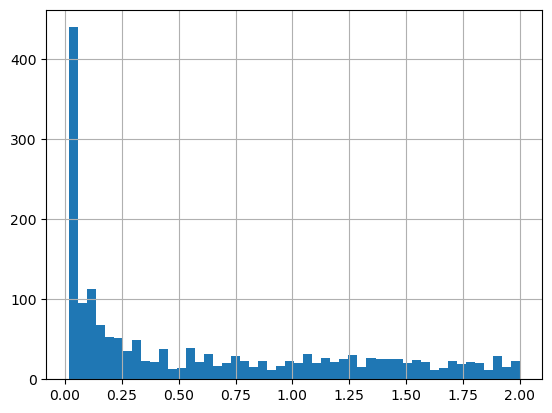

In [25]:
hist = combined_df[(combined_df.interaction_time_delta != 0) & (combined_df.interaction_time_delta <= 2)]['interaction_time_delta'].hist(bins=50)

In [26]:
serialized_time_delta = combined_df.groupby('session')['interaction_time_delta'].agg(lambda x: ' '.join(map(str, x))).reset_index()
serialized_time_delta['interaction_time_delta_list'] = serialized_time_delta['interaction_time_delta'].str.split()

if sequence_split == True:
    serialized_time_delta['interaction_time_delta_list'] = serialized_time_delta['interaction_time_delta_list'].apply(lambda x: x[:-2])
else:
    serialized_time_delta['interaction_time_delta_list'] = serialized_time_delta['interaction_time_delta_list'].apply(lambda x: x[:-1])
serialized_time_delta['interaction_time_delta_train'] = serialized_time_delta['interaction_time_delta_list'].apply(lambda x: ' '.join(x))
serialized_time_delta

,session,interaction_time_delta,interaction_time_delta_list,interaction_time_delta_train
0,7.0,0.0,[],
1,16.0,0.0 0.0 10.217 21.733 19.117,"[0.0, 0.0, 10.217, 21.733]",0.0 0.0 10.217 21.733
2,20.0,0.0,[],
3,25.0,0.0 0.033 0.0,"[0.0, 0.033]",0.0 0.033
4,27.0,0.0,[],
...,...,...,...,...
1629,5386.0,0.0,[],
1630,5387.0,0.0 0.483,[0.0],0.0
1631,5388.0,0.0 8.517,[0.0],0.0
1632,5389.0,0.0 0.0 75.917,"[0.0, 0.0]",0.0 0.0


In [27]:
serialized_df = combined_df.groupby('session')['Label_tokens'].agg(lambda x: ' '.join(map(str, x))).reset_index()
session_vehicle_dict = dict(zip(combined_df['session'], combined_df['vehicle']))

serialized_df['Label_tokens_list'] = serialized_df['Label_tokens'].str.split()
serialized_df['Label_tokens_list_int'] = serialized_df['Label_tokens_list'].apply(lambda x: list(map(int, x)))
serialized_df = serialized_df[serialized_df['Label_tokens_list_int'].apply(lambda x: len(set(x)) > 1)]

serialized_df['item_id_seq_test'] = serialized_df['Label_tokens_list'].apply(lambda x: ' '.join(x[:-1]))
serialized_df['item_id_test'] = serialized_df['Label_tokens_list'].apply(lambda x: x[-1] if len(x) > 0 else None)
serialized_df = serialized_df.drop(columns=['Label_tokens_list'])
serialized_df = serialized_df[serialized_df['item_id_seq_test'] != ''].drop(columns=['Label_tokens'])

serialized_df['Label_tokens_list'] = serialized_df['item_id_seq_test'].str.split()
serialized_df['item_id_seq_train'] = serialized_df['Label_tokens_list'].apply(lambda x: ' '.join(x[:-1]))
serialized_df['item_id_train'] = serialized_df['Label_tokens_list'].apply(lambda x: x[-1] if len(x) > 0 else None)
serialized_df = serialized_df.drop(columns=['Label_tokens_list'])
if sequence_split:
    serialized_df = serialized_df[serialized_df['item_id_seq_train'] != '']
else:
    serialized_df = serialized_df[serialized_df['item_id_seq_test'] != '']

serialized_df['vehicle'] = serialized_df['session'].map(session_vehicle_dict)
serialized_df = serialized_df.drop(columns=['vehicle'])
#serialized_df.rename(columns={'session': 'session_id'}, inplace=True)
serialized_df['session_id'] = range(len(serialized_df))
serialized_df['session_id'] = serialized_df['session_id'].astype(int)
merged_df = serialized_df.merge(serialized_time_delta, on='session', how='inner')

In [35]:
if sequence_split == True:
    test_df = merged_df[['session_id', 'item_id_seq_test', 'item_id_test', 'interaction_time_delta_train']]
    train_df = merged_df[['session_id', 'item_id_seq_train', 'item_id_train', 'interaction_time_delta_train']]
    test_df.to_csv('../datasets/sequential/carsii_timedelta_seq/test.tsv', sep='\t', index=False)
    train_df.to_csv('../datasets/sequential/carsii_timedelta_seq/train.tsv', sep='\t', index=False)
elif random_split == True:
    merged_df = merged_df[['session_id', 'item_id_seq_test', 'item_id_test', 'interaction_time_delta_train']]
    train_df, test_df = train_test_split(merged_df, test_size=0.2)
    test_df['session_id'] = range(len(test_df))
    test_df['session_id'] = test_df['session_id'].astype(int)

    train_df['session_id'] = range(len(train_df))
    train_df['session_id'] = train_df['session_id'].astype(int)

    test_df.to_csv('../datasets/sequential/carsii_timedelta_rand_seq/test.tsv', sep='\t', index=False)
    train_df.to_csv('../datasets/sequential/carsii_timedelta_rand_seq/train.tsv', sep='\t', index=False)